### Imports and aligning the Datasets

In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
pd.options.mode.chained_assignment = None
from datetime import date
from scipy.stats import permutation_test

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams.update({'font.size': 15})
plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=15)

Sentiment predictions by page number and publication company.

In [107]:
pre_page_df = pd.read_csv('csv/us_apr-feb2021_publisher_page_df.csv', index_col=[0]).iloc[:, 3:]
post_page_df = pd.read_csv('csv/publisher_page_us-mar-apr2022.csv', index_col=[0]).iloc[:, 3:]
pre_publisher_df = pd.read_csv('csv/us_apr-feb2021_publisher_page_df.csv', index_col=[0]).iloc[:, :3]
post_publisher_df = pd.read_csv('csv/publisher_page_us-mar-apr2022.csv', index_col=[0]).iloc[:, :3]
publisher_df = pd.merge(pre_publisher_df, post_publisher_df, on='publisher_name', how='inner')
page_df = pd.merge(pre_page_df, post_page_df, on='page', how='inner')

page_df['sentiment'] = page_df.eval("(page_prediction_x + page_prediction_y) / (total_page_x + total_page_y)")
publisher_df['sentiment'] = publisher_df.eval('(publisher_prediction_x+publisher_prediction_y)/(total_published_y + total_published_x)')
page_df = page_df[['page', 'sentiment']]
publisher_df = publisher_df[['publisher_name', 'sentiment']]

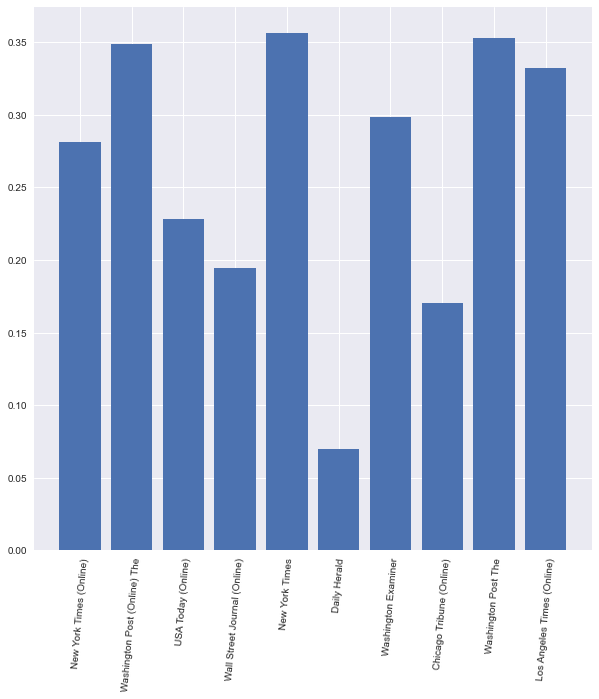

In [108]:
plot_pub = publisher_df.head(10)
plt.figure(figsize=(10,10))
plt.bar(x=plot_pub.publisher_name, height=plot_pub.sentiment*-1)
plt.xticks(rotation=85);

In [81]:
health_data_df = pd.read_csv('csv/us_cleaned_health_data.csv', parse_dates=['date'])
pre_df = pd.read_csv('csv/us_apr-feb2021.csv', index_col=[0], parse_dates=['date'])
post_df = pd.read_csv('csv/us-mar-apr2022.csv', index_col=[0], parse_dates=['date'])
df = pd.concat((pre_df,post_df),axis=0)

health_data_df = health_data_df[(health_data_df.date >= df.date.min()) & (health_data_df.date <= df.date.max())]
health_data_df = health_data_df[['new_cases_smoothed', 'new_deaths_smoothed', 'weekly_hosp_admissions', 
                                'new_vaccinations_smoothed','positive_rate', 'new_cases', 'date']]
df = df.merge(health_data_df, on='date')
df = df.set_index('date', drop=False)

df['smoothed_prediction'] = df.prediction.rolling(window=5, center=True, win_type='gaussian').mean(std=2)
df['smoothed_articles_per_day'] = df.articles_per_day.rolling(window=4, center=True, win_type='gaussian').mean(std=1)

In [83]:
print(f'The average sentiment score for articles is {np.around(df.prediction.mean(),3)}')
# print(f'The average sentiment score for titles is {np.around(us_titles.title_prediction.mean(),3)}')
# print(f'The average sentiment score for non-covid articles is {np.around(reg_df.prediction.mean(),3)}')

The average sentiment score for articles is -0.184


In [86]:
pre_delta = df[(df.date >= '2020-12-15') & (df.date < '2021-06-01')]
predictor_list = ['new_cases', 'new_cases_smoothed', 'new_deaths_smoothed','weekly_hosp_admissions', 'new_vaccinations_smoothed', 'positive_rate']
predictor_list_noVax = predictor_list[:-1]

['new_cases', 'new_cases_smoothed', 'new_deaths_smoothed', 'weekly_hosp_admissions', 'new_vaccinations_smoothed', 'positive_rate']
['new_cases', 'new_cases_smoothed', 'new_deaths_smoothed', 'weekly_hosp_admissions', 'positive_rate']


<AxesSubplot:>

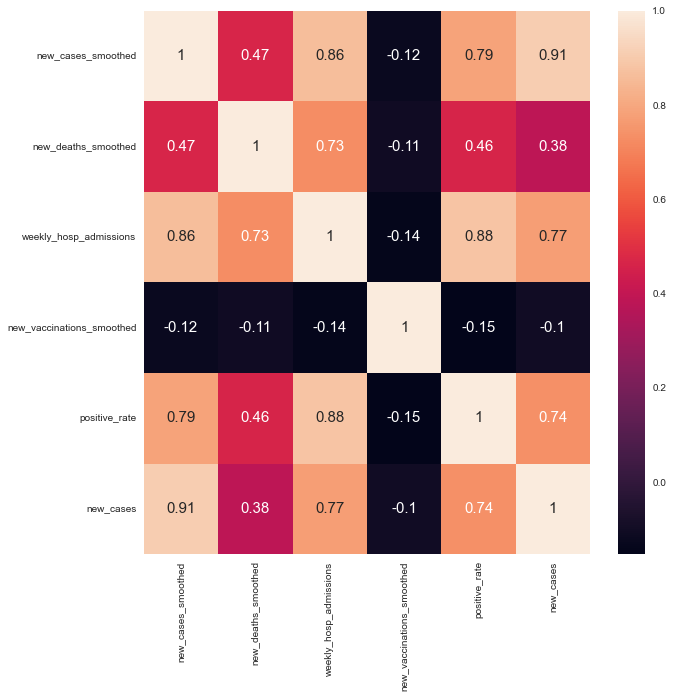

In [109]:
plt.figure(figsize=(10,10))
sns.heatmap(health_data_df.corr(), annot=True)

In [127]:
pre_delta.corr().loc['weekly_hosp_admissions','positive_rate']
# df[df.date >= '2022-01-01'].corr().loc['weekly_hosp_admissions','weekly_positive_rate']


KeyboardInterrupt



### Permutation Testing the Correlations

In [89]:
df_corr = df_corr.dropna(axis=0, subset=['positive_rate'])

In [90]:
res = permutation_test(data=(df_corr['smoothed_prediction'].values, df_corr['new_cases_smoothed'].values), statistic=stats.pearsonr, 
                    permutation_type='pairings', n_resamples=30000, alternative='two-sided')

In [91]:
def calc_corr(dataframe, predictor, spearman=False, kend=False):
    """_summary_

    Args:
        dataframe (_type_): _description_
        predictor (_type_): _description_
        spearman (bool, optional): _description_. Defaults to False.
        kend (bool, optional): _description_. Defaults to False.

    Returns:
        tuple(float, float): Correlation between predictor and sentiment. P-value of correlation
    """
    avg_prediction = dataframe['smoothed_prediction']
    predictor = dataframe[predictor]

    if kend:
        first_corr, _ = stats.kendalltau(avg_prediction, predictor)
        res = permutation_test(data=(avg_prediction, predictor), statistic=stats.kendalltau, 
                        permutation_type='pairings', n_resamples=20000, alternative='two-sided')
        p_val = list(res.pvalue)[0]
        return np.around(first_corr,3), np.around(p_val,5)
    
    elif spearman:
        first_corr, _ = stats.spearmanr(avg_prediction, predictor)
        res = permutation_test(data=(avg_prediction, predictor), statistic=stats.spearmanr, 
                        permutation_type='pairings', n_resamples=20000, alternative='two-sided')
        p_val = list(res.pvalue)[1]
        return np.around(first_corr,3), np.around(p_val,5)
    
    else:
        first_corr, _ = stats.pearsonr(avg_prediction, predictor)
        res = permutation_test(data=(avg_prediction, predictor), statistic=stats.pearsonr, 
                        permutation_type='pairings', n_resamples=20000, alternative='two-sided')
        p_val = list(res.pvalue)[0]
        return np.around(first_corr,3), np.around(p_val,5)

def run_corr(dataframe, predictor_list):
    pearson_corr = []
    pearson_p_val = []
    for predictor in predictor_list:
        corr, p_val = calc_corr(dataframe, predictor)
        pearson_corr.append(corr)
        pearson_p_val.append(p_val)

    spearman_corr = []
    spearman_p_val = []
    for predictor in predictor_list:
        corr, p_val = calc_corr(dataframe, predictor, spearman=True)
        spearman_corr.append(corr)
        spearman_p_val.append(p_val)

    kendal_corr = []
    kendal_p_val = []
    for predictor in predictor_list:
        corr, p_val = calc_corr(dataframe, predictor, kend=True)
        kendal_corr.append(corr)
        kendal_p_val.append(p_val)
        
    return pearson_corr, pearson_p_val, spearman_corr, spearman_p_val, kendal_corr, kendal_p_val

**Pre Delta Timeline and After Vaccinations**

In [92]:
pearson_corr, pearson_p_val, spearman_corr, spearman_p_val, kendal_corr, kendal_p_val = run_corr(dataframe=pre_delta, predictor_list=predictor_list)

/opt/homebrew/Caskroom/miniforge/base/envs/covid/lib/python3.9/site-packages/scipy/stats/_hypotests.py:1587: RuntimeWarning: overflow encountered in double_scalars
  n_max = factorial(n_obs_sample)**n_samples


KeyboardInterrupt: 

In [ ]:
pre_delta_df = pd.DataFrame({'Pearson Correlation' : pearson_corr,'Spearman Correlation' : spearman_corr, 'Kendall Correlation' : kendal_corr})
pre_delta_p_val_df = pd.DataFrame({'Pearson p-value': pearson_p_val, 'Spearman p-value': spearman_p_val, 'Kendall p-value': kendal_p_val})
pre_delta_df.index = predictor_list
pre_delta_p_val_df.index = predictor_list
pre_delta_df

,Pearson Correlation,Spearman Correlation,Kendall Correlation
new_cases,-0.783,-0.798,-0.597
new_cases_smoothed,-0.827,-0.877,-0.684
new_deaths_smoothed,-0.731,-0.749,-0.532
weekly_hosp_admissions,-0.838,-0.891,-0.711
new_vaccinations_smoothed,0.498,0.491,0.293
positive_rate,-0.858,-0.902,-0.728


In [ ]:
pre_delta_df = pd.DataFrame({'Pearson Correlation' : pearson_corr,'Spearman Correlation' : spearman_corr, 'Kendall Correlation' : kendal_corr})
pre_delta_p_val_df = pd.DataFrame({'Pearson p-value': pearson_p_val, 'Spearman p-value': spearman_p_val, 'Kendall p-value': kendal_p_val})
pre_delta_df.index = predictor_list
pre_delta_p_val_df.index = predictor_list
pre_delta_df

,Pearson Correlation,Spearman Correlation,Kendall Correlation
new_cases,-0.783,-0.798,-0.597
new_cases_smoothed,-0.827,-0.877,-0.684
new_deaths_smoothed,-0.731,-0.749,-0.532
weekly_hosp_admissions,-0.838,-0.891,-0.711
new_vaccinations_smoothed,0.498,0.491,0.293
positive_rate,-0.858,-0.902,-0.728


In [ ]:
pre_delta_p_val_df.index = predictor_list
pre_delta_p_val_df

,Pearson p-value,Spearman p-value,Kendall p-value
new_cases,0.0001,0.0001,0.0001
new_cases_smoothed,0.0001,0.0001,0.0001
new_deaths_smoothed,0.0001,0.0001,0.0001
weekly_hosp_admissions,0.0001,0.0001,0.0001
new_vaccinations_smoothed,0.0001,0.0001,0.0001
positive_rate,0.0001,0.0001,0.0001


In [ ]:
with open('latex_tables/pre_delt_corr.tex', 'w') as tf:
    tf.write(pre_delta_df.to_latex(index=True))

/var/folders/7b/prbmv40d5wg4ymrn9dr3c76c0000gn/T/ipykernel_59389/3640056865.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(pre_delta_df.to_latex(index=True))


**Entire Timeline**

In [ ]:
pearson_corr, pearson_p_val, spearman_corr, spearman_p_val, kendal_corr, kendal_p_val = run_corr(dataframe=non_na_df, predictor_list=predictor_list)

KeyboardInterrupt: 

In [ ]:
correlations_df = pd.DataFrame({'Pearson Correlation' : pearson_corr,'Spearman Correlation' : spearman_corr, 'Kendall Correlation' : kendal_corr})
p_val_df = pd.DataFrame({'Pearson p-value': pearson_p_val, 'Spearman p-value': spearman_p_val, 'Kendall p-value': kendal_p_val})
correlations_df.index = predictor_list
p_val_df.index = predictor_list
correlations_df

,Pearson Correlation,Spearman Correlation,Kendall Correlation
new_cases,-0.447,-0.503,-0.353
new_cases_smoothed,-0.461,-0.554,-0.395
new_deaths_smoothed,-0.109,-0.107,-0.077
weekly_hosp_admissions,-0.506,-0.516,-0.363
new_vaccinations_smoothed,0.345,0.275,0.161
positive_rate,-0.595,-0.694,-0.505


In [ ]:
correlations_df = pd.DataFrame({'Pearson Correlation' : pearson_corr,'Spearman Correlation' : spearman_corr, 'Kendall Correlation' : kendal_corr})
p_val_df = pd.DataFrame({'Pearson p-value': pearson_p_val, 'Spearman p-value': spearman_p_val, 'Kendall p-value': kendal_p_val})
correlations_df.index = predictor_list
p_val_df.index = predictor_list
correlations_df

,Pearson Correlation,Spearman Correlation,Kendall Correlation
new_cases,-0.441,-0.570,-0.404
new_cases_smoothed,-0.449,-0.624,-0.451
new_deaths_smoothed,-0.167,-0.179,-0.125
weekly_hosp_admissions,-0.557,-0.611,-0.435
new_vaccinations_smoothed,0.295,0.246,0.148
positive_rate,-0.597,-0.748,-0.557


In [ ]:
p_val_df

,Pearson p-value,Spearman p-value,Kendall p-value
new_cases,0.0001,0.0001,0.0001
new_cases_smoothed,0.0001,0.0001,0.0001
new_deaths_smoothed,0.0001,0.0003,0.0001
weekly_hosp_admissions,0.0001,0.0001,0.0001
new_vaccinations_smoothed,0.0001,0.0001,0.0001
positive_rate,0.0001,0.0001,0.0001


In [ ]:
df_corr.dropna(axis=1)

,date,prediction,articles_per_day,new_cases_smoothed,new_deaths_smoothed,positive_rate,new_cases,smoothed_prediction
2,2020-04-03,-0.237234,1393.0,26096.857,1036.714,0.207,32401.0,-0.273093
3,2020-04-04,-0.309091,915.0,27479.857,1163.857,0.209,31845.0,-0.262518
4,2020-04-05,-0.243336,1064.0,29353.143,1315.429,0.210,29240.0,-0.261413
5,2020-04-06,-0.255991,1072.0,30728.571,1463.286,0.211,31782.0,-0.265095
6,2020-04-07,-0.251962,1268.0,31250.714,1677.143,0.208,30036.0,-0.243906
...,...,...,...,...,...,...,...,...
744,2022-04-15,-0.259259,104.0,32201.286,448.714,0.049,35406.0,-0.217199
745,2022-04-16,-0.213115,74.0,32148.714,435.571,0.051,12280.0,-0.168137
746,2022-04-17,-0.056140,115.0,31765.286,433.286,0.052,6769.0,-0.199776
747,2022-04-18,-0.270588,120.0,34469.286,422.286,0.054,60691.0,-0.184374


In [ ]:
pearson_corr, pearson_p_val, spearman_corr, spearman_p_val, kendal_corr, kendal_p_val = run_corr(dataframe=df_corr.dropna(axis=1), predictor_list=non_na_preds)

In [ ]:
correlations_df = pd.DataFrame({'Pearson Correlation' : pearson_corr,'Spearman Correlation' : spearman_corr, 'Kendall Correlation' : kendal_corr})
p_val_df = pd.DataFrame({'Pearson p-value': pearson_p_val, 'Spearman p-value': spearman_p_val, 'Kendall p-value': kendal_p_val})
correlations_df.index = non_na_preds
p_val_df.index = non_na_preds
correlations_df

,Pearson Correlation,Spearman Correlation,Kendall Correlation
new_cases,-0.257,-0.280,-0.198
new_cases_smoothed,-0.248,-0.244,-0.181
new_deaths_smoothed,0.055,0.087,0.064
positive_rate,-0.466,-0.567,-0.398


In [ ]:
pearson_corr, pearson_p_val, spearman_corr, spearman_p_val, kendal_corr, kendal_p_val = run_corr(dataframe=reg_df, predictor_list=predictor_list)

In [ ]:
correlations_df = pd.DataFrame({'Pearson Correlation' : pearson_corr,'Spearman Correlation' : spearman_corr, 'Kendall Correlation' : kendal_corr})
p_val_df = pd.DataFrame({'Pearson p-value': pearson_p_val, 'Spearman p-value': spearman_p_val, 'Kendall p-value': kendal_p_val})
correlations_df.index = non_na_preds
p_val_df.index = non_na_preds
correlations_df

,Pearson Correlation,Spearman Correlation,Kendall Correlation
new_cases,-0.295,-0.393,-0.277
new_cases_smoothed,-0.281,-0.372,-0.278
new_deaths_smoothed,-0.001,-0.016,-0.006
weekly_hosp_admissions,-0.347,-0.370,-0.267
positive_rate,-0.431,-0.559,-0.398


In [ ]:
with open('latex_tables/corr_all.tex', 'w') as tf:
    tf.write(correlations_df.to_latex(index=True))
    
with open('latex_tables/p_val_all.tex', 'w') as tf:
    tf.write(p_val_df.to_latex(index=True))

/var/folders/7b/prbmv40d5wg4ymrn9dr3c76c0000gn/T/ipykernel_25905/3705991204.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(correlations_df.to_latex(index=True))
/var/folders/7b/prbmv40d5wg4ymrn9dr3c76c0000gn/T/ipykernel_25905/3705991204.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(p_val_df.to_latex(index=True))


##### Granger Causality Test

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

test_df = df.dropna(axis=0, subset=['smoothed_prediction', 'positive_rate'])
test_df.smoothed_prediction.isna().sum()

0

In [ ]:
adfuller(test_df['smoothed_prediction'])

(-2.8611807371120106,
 0.0500519581646486,
 18,
 728,
 {'1%': -3.4393644334758475,
  '5%': -2.8655182850048306,
  '10%': -2.568888486973192},
 -4667.64931726111)

In [ ]:
adfuller(test_df['positive_rate'])

(-4.0492261941031655,
 0.001173587206430041,
 10,
 736,
 {'1%': -3.4392661055744767,
  '5%': -2.86547495466493,
  '10%': -2.56886540295664},
 -7803.271055178704)

In [ ]:
# df_transformed = test_df.diff(1).dropna()
# adfuller(df_transformed['smoothed_prediction'])

(-4.4578021634051614,
 0.00023420231440574363,
 18,
 472,
 {'1%': -3.444280551073031,
  '5%': -2.867682902679315,
  '10%': -2.5700419306592934},
 -2476.9741977820495)

In [ ]:
# Reject Ho means that positive Rate influences the sentiment  
grangercausalitytests(test_df[['positive_rate', 'smoothed_prediction']], maxlag=6)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=66.2317 , p=0.0000  , df_denom=743, df_num=1
ssr based chi2 test:   chi2=66.4991 , p=0.0000  , df=1
likelihood ratio test: chi2=63.7003 , p=0.0000  , df=1
parameter F test:         F=66.2317 , p=0.0000  , df_denom=743, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5379  , p=0.0797  , df_denom=740, df_num=2
ssr based chi2 test:   chi2=5.1100  , p=0.0777  , df=2
likelihood ratio test: chi2=5.0926  , p=0.0784  , df=2
parameter F test:         F=2.5379  , p=0.0797  , df_denom=740, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5219  , p=0.2075  , df_denom=737, df_num=3
ssr based chi2 test:   chi2=4.6092  , p=0.2028  , df=3
likelihood ratio test: chi2=4.5950  , p=0.2040  , df=3
parameter F test:         F=1.5219  , p=0.2075  , df_denom=737, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5799  , p=0.1778  

{1: ({'ssr_ftest': (66.23167645702108, 1.685636555367604e-15, 743.0, 1),
   'ssr_chi2test': (66.49909910758778, 3.500535496557985e-16, 1),
   'lrtest': (63.70034708580715, 1.4485905953706181e-15, 1),
   'params_ftest': (66.23167645702027, 1.685636555368203e-15, 743.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.537850329371234, 0.07972386541408734, 740.0, 2),
   'ssr_chi2test': (5.109995933463701, 0.07769239003660393, 2),
   'lrtest': (5.092550788069275, 0.07837303171452811, 2),
   'params_ftest': (2.537850329365491, 0.07972386541454593, 740.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.5219343644288632, 0.20745376136161553, 737.0, 3),
   'ssr_chi2test': (4.609168929993517, 0.2027569340395861, 3),
   'lrtest': (4.594950447017254, 0.20397568609632993, 3),
   'params_ftest': (1.521934364429109, 0.2074537613615568, 737.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 

In [ ]:
# Cross Correlation:
correlation_c = np.correlate(test_df.positive_rate, test_df.smoothed_prediction, 'full')

In [ ]:
dfc = pre_delta.diff(5).dropna()

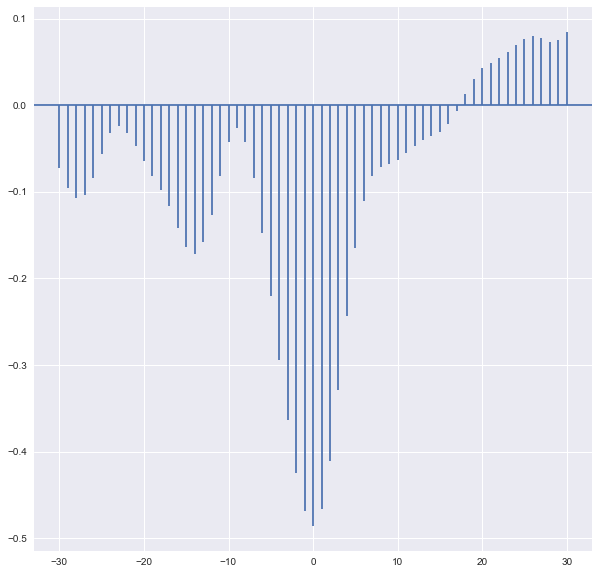

In [ ]:
plt.xcorr(dfc.positive_rate, dfc.smoothed_prediction, usevlines=1, maxlags=30);

In [ ]:
g_label = stats.pearsonr(df_corr.positive_rate, df_corr.smoothed_prediction)
sns.regplot(x='new_cases_smoothed', y='smoothed_prediction', data=df_corr, scatter_kws={'alpha':0.50}, 
            line_kws={'color': 'k', 'label':f'Pearson Correlation = {round(g_label[0],3)}'})
plt.legend()

ValueError: array must not contain infs or NaNs

<AxesSubplot:xlabel='positive_rate', ylabel='Count'>

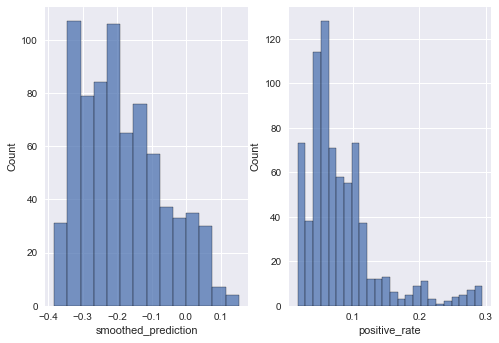

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
sns.histplot(df.smoothed_prediction,  ax=ax1)
sns.histplot(df.positive_rate, ax=ax2)

## Plotting the data

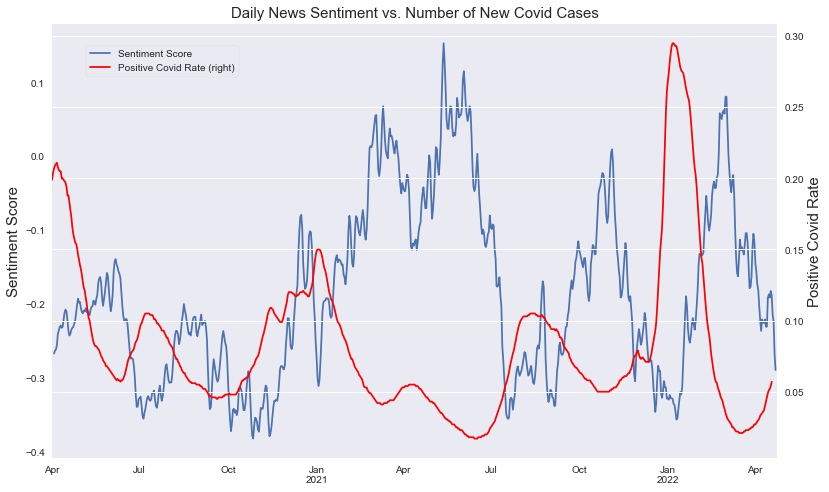

In [100]:
ax = df.plot(y="smoothed_prediction", legend=False, figsize=(13,8), label='Sentiment Score')
ax2 = df.plot(y="positive_rate", secondary_y=True,ax=ax, legend=False, color="r", label='Positive Covid Rate')

ax.figure.legend(bbox_to_anchor=(0.33, 0.85), frameon=True)
plt.title('Daily News Sentiment vs. Number of New Covid Cases')
ax.set_ylabel('Sentiment Score')
ax2.set_ylabel('Positive Covid Rate')
ax.set_xlabel('')
plt.savefig('figures/entire_timeline_comparison.png', dpi=500)

In [ ]:
# ax = us_titles.plot(x="date", y="title_prediction", legend=False, color ='r',figsize=(13,8), label='Headline Sentiment')
# ax2 = ax.twinx()
# df.plot(x="date", y="avg_predict", ax=ax2, legend=False, label='Article Sentiment')

# ax.figure.legend(bbox_to_anchor=(0.3, 0.85), fontsize=13)
# # plt.title('Comparing Average Daily Article Sentiment Against New Covid Cases')
# ax.set_ylabel('Headline Sentiment Score', fontsize=14)
# ax2.set_ylabel('Article Sentiment Score', fontsize=14)
# ax.set_xlabel('Date', fontsize=14)

# plt.savefig('figures/article sentiment vs headline sentiment.png', dpi=500)

NameError: name 'us_titles' is not defined

In [ ]:
# ax = us_titles.plot(x="date", y="smoothed_prediction", legend=False, figsize=(13,8), label='Sentiment Score')
# ax2 = ax.twinx()
# us_titles.plot(x="date", y="positive_rate", ax=ax2, legend=False, color="r", label='Positive Covid Rate')

# ax.figure.legend(bbox_to_anchor=(0.3, 0.85))
# plt.title('Comparing Average Daily Article Sentiment Against New Covid Cases')
# ax.set_ylabel('Sentiment Score', fontsize=14)
# ax2.set_ylabel('Positive Covid Rate', fontsize=14)
# ax.set_xlabel('Date', fontsize=14)

# # plt.savefig('figures/pos_rate_compar_entire_timeline.png')

NameError: name 'us_titles' is not defined

In [101]:
# ax = reg_df.plot(x="date", y="avg_predict", legend=False, figsize=(13,8), label='Sentiment Score')
# ax2 = ax.twinx()
# reg_df.plot(x="date", y="positive_rate", ax=ax2, legend=False, color="r", label = 'Positive Rate')

# ax.figure.legend(bbox_to_anchor=(0.88, 0.88))
# # plt.title('Daily Articles Published vs. Positive Rate')
# ax.set_ylabel('Sentiment Score', fontsize=12)
# ax2.set_ylabel('Positive Covid Rate', fontsize=12)
# ax.set_xlabel('Date', fontsize=14)
# plt.savefig('figures/regular_news_trend.png', dpi=500)

**Daily articles Published**

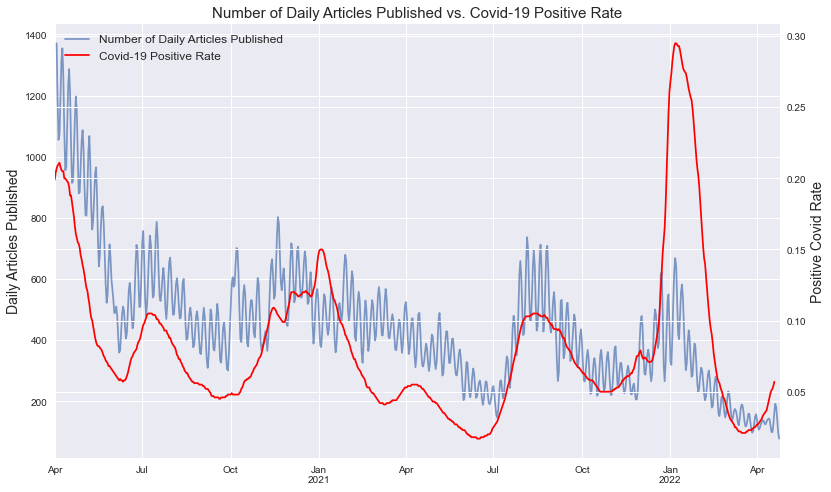

In [102]:
ax = df.plot(y="smoothed_articles_per_day", legend=False, figsize=(13,8), label='Number of Daily Articles Published', alpha=0.7, style='-')
ax2 = ax.twinx()
df.plot(y="positive_rate", ax=ax2, legend=False, color="r", label = 'Covid-19 Positive Rate')


ax.figure.legend(bbox_to_anchor=(0.38, 0.88), fontsize=12)
plt.title('Number of Daily Articles Published vs. Covid-19 Positive Rate', fontsize=15)
ax.set_ylabel('Daily Articles Published', fontsize=14)
ax2.set_ylabel('Positive Covid Rate', fontsize=14)
ax.set_xlabel('', fontsize=14)

plt.savefig('figures/num_articles_published.png', dpi=500)

In [ ]:
df[['smoothed_articles_per_day', 'positive_rate']].corr('spearman')

,smoothed_articles_per_day,positive_rate
smoothed_articles_per_day,1.000000,0.593479
positive_rate,0.593479,1.000000


#### Double check the timeline parts

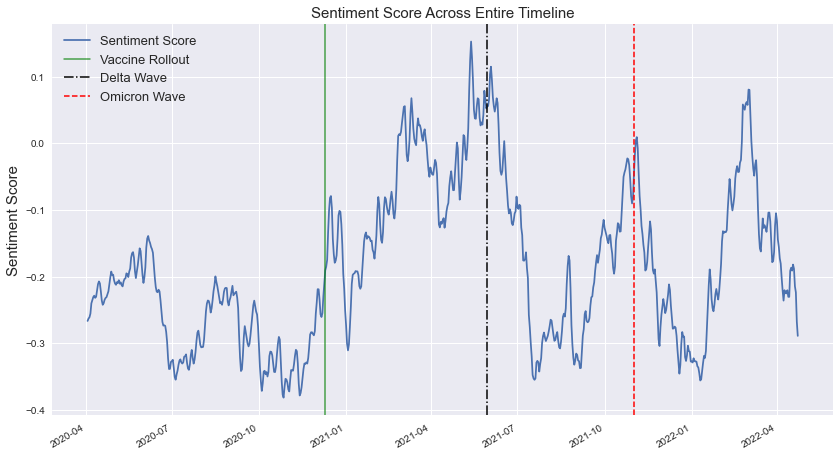

In [129]:
fig = plt.figure(figsize=(14,8))
sns.lineplot(data=df, x='date', y='smoothed_prediction', label='Sentiment Score')
fig.autofmt_xdate()
plt.xlabel('')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score Across Entire Timeline')

plt.axvline(x=pd.to_datetime('2020-12-10'), color='g', linestyle='-',linewidth=1.5, label='Vaccine Rollout', alpha=0.7)
plt.axvline(x=pd.to_datetime('2021-05-30'), color='k', linestyle='-.',linewidth=1.5, label='Delta Wave')
plt.axvline(x=pd.to_datetime('2021-11-01'), color='r', linestyle='--',linewidth=1.5, label='Omicron Wave')

plt.legend(loc='upper left', fontsize=13, ncol=1,)
plt.savefig('figures/us_sentiment_3hlines.png', dpi=500)

In [ ]:
# plt.figure(figsize=(14,8))
# sns.lineplot(data=df, x='date', y='avg_predict', label='sentiment score')
# plt.ylabel('Sentiment Score',fontsize=15)
# plt.xlabel('Date', fontsize=15)
# plt.title('Sentiment Score Across Entire Timeline',fontsize=15)
# plt.axvline(x=pd.to_datetime('2021-06-01'), color='k', linestyle='-.',linewidth=1.5, label='Delta wave')
# plt.axvline(x=pd.to_datetime('2021-11-01'), color='r', linestyle='--',linewidth=1.5, label='Omicron wave')
# plt.axvline(x=pd.to_datetime('2021-01-10'), color='g', linestyle=':',linewidth=3, label='Vaccine rollout')
# plt.axhline(y=0, color='k', linestyle='--', linewidth=0.75)
# plt.legend(loc='upper left')
# plt.savefig('figures/sentiment_entire_timeline_3hlines.png')

In [132]:
# fig, axs = plt.subplots(ncols=2, figsize=(12,6))
# sns.regplot(x=pre_delta.positive_rate, y=pre_delta.smoothed_prediction, ax=axs[0], label=f"correlation = {pre_delta_df.loc['positive_rate']['Pearson Correlation']}");
# axs[0].set_title('(January-June) Sentiment Score vs. Covid Positivity Rate');
# axs[0].set_ylabel('predicted sentiment score');
# axs[0].legend()

# sns.regplot(x=pre_delta.new_vaccinations_smoothed, y=pre_delta.smoothed_prediction, ax=axs[1], order=2, 
#                             label=f"correlation = {pre_delta_df.loc['new_vaccinations_smoothed'].max()}");
# axs[1].set_title('(January-June) Sentiment Score vs. New Vaccinations Administered');
# axs[1].set_ylabel('predicted sentiment score');
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.4, hspace=None)
# axs[1].legend()
# plt.savefig('figures/pre-delt_corr_vaccines & pos_rate.png')

## Isolating for specific correlation timelines

In [ ]:
overall_mean = df.prediction.mean()
print(f'average score across the entire timeline: {round(overall_mean,3)}')

def percent_change(avg):
    if avg > overall_mean:
        return np.around(((overall_mean - avg)/ overall_mean) * 100, 1)
    else:
        return np.around(((avg - overall_mean) / overall_mean) * -100, 1)

average_sentiment = []
percent_change_avg = []

average score across the entire timeline: -0.184


**Rereading the data in to reset the changes made from before**

In [ ]:
# us_df = pd.read_csv('csv/us_cleaned_health_data.csv') # Health Data
# pre_df = pd.read_csv('csv/NS_sep-dec2020.csv')
# df = pd.read_csv('csv/NS_jan-dec2021.csv')
# post_df = pd.read_csv('csv/NS_jan2022-mar2022.csv')
# df = pd.concat((pre_df, df, post_df),axis=0)
# df.drop('Unnamed: 0', axis=1, inplace=True)

# reg_df = pd.read_csv('csv/NS_regular_jan-dec2021.csv')
# daily_articles = pd.read_csv('csv/num_daily_articles.csv')
# us_titles = pd.read_csv('csv/NS_titles_jan-dec2021.csv')

# can_df = pd.read_csv('csv/NS_canada.csv')
# aus_df = pd.read_csv('csv/NS_australia_jan-dec2021.csv')

# df.date = pd.to_datetime(df.date)
# reg_df.date = pd.to_datetime(reg_df.date)
# us_df.date = pd.to_datetime(us_df.date)
# daily_articles.date = pd.to_datetime(daily_articles.date)
# us_titles.date = pd.to_datetime(us_titles.date)

# us_df = us_df[(us_df.date >= df.date.min()) & (us_df.date <= df.date.max())]
# us_df = us_df[['new_cases_smoothed', 'new_deaths_smoothed', 'weekly_hosp_admissions', 'new_vaccinations_smoothed', 
#                 'positive_rate', 'new_cases', 'date']]

# reg_df = reg_df.merge(us_df,on='date')
# df = df.merge(us_df, on='date')
# daily_articles = daily_articles.merge(df, on='date')

# df['avg_predict'] = df.prediction.rolling(window=4, center=True).mean()
# reg_df['avg_predict'] = reg_df.prediction.rolling(window=4, center=True).mean()

# df_corr = df.dropna(axis=0, subset='avg_predict')
# reg_df.dropna(axis=0, subset='avg_predict', inplace=True)

# daily_articles.rename({'article_id': 'num_articles'},axis=1, inplace=True)
# df = pd.concat((df, daily_articles.num_articles), axis=1)

In [ ]:
health_data_df = pd.read_csv('csv/us_cleaned_health_data.csv') # Health Data
pre_df = pd.read_csv('csv/us_apr-feb2021.csv', index_col=[0])
post_df = pd.read_csv('csv/us-mar-apr2022.csv', index_col=[0])
df = pd.concat((pre_df,post_df),axis=0)

# reg_df = pd.read_csv('csv/NS_regular_jan-dec2021.csv')
# daily_articles = pd.read_csv('csv/num_daily_articles.csv')
# us_titles = pd.read_csv('csv/NS_titles_jan-dec2021.csv').rename(columns={'prediction': 'title_prediction'})
# can_df = pd.read_csv('csv/NS_canada.csv',index_col=[0])
# aus_df = pd.read_csv('csv/NS_australia_jan-dec2021.csv', index_col=[0])

# reg_df.date = pd.to_datetime(reg_df.date)
df.date = pd.to_datetime(df.date)
health_data_df.date = pd.to_datetime(health_data_df.date)
# daily_articles.date = pd.to_datetime(daily_articles.date)
# us_titles.date = pd.to_datetime(us_titles.date)

health_data_df = health_data_df[(health_data_df.date >= df.date.min()) & (health_data_df.date <= df.date.max())]
health_data_df = health_data_df[['new_cases_smoothed', 'new_deaths_smoothed', 'weekly_hosp_admissions', 'new_vaccinations_smoothed', 
                'positive_rate', 'new_cases', 'date']]

# reg_df = reg_df.merge(health_data_df,on='date')
df = df.merge(health_data_df, on='date')

df['smoothed_prediction'] = df.prediction.rolling(window=8, center=True, win_type='gaussian').mean(std=3)
# df['smoothed_prediction'] = df.prediction.rolling(window=10, center=True, win_type='gaussian').sum(std=5)
# reg_df['avg_predict'] = reg_df.prediction.rolling(window=4, center=True).mean()
# us_titles['title_prediction'] = us_titles['title_prediction'].rolling(window=4,center=True).mean()
df_corr = df.dropna(axis=0, subset='smoothed_prediction')
# reg_df.dropna(axis=0, subset='avg_predict', inplace=True)

In [ ]:
non_na_preds = df.drop('new_vaccinations_smoothed',axis=1).columns[4:]
non_na_preds

Index(['new_deaths_smoothed', 'weekly_hosp_admissions', 'positive_rate',
       'new_cases', 'smoothed_prediction'],
      dtype='object')

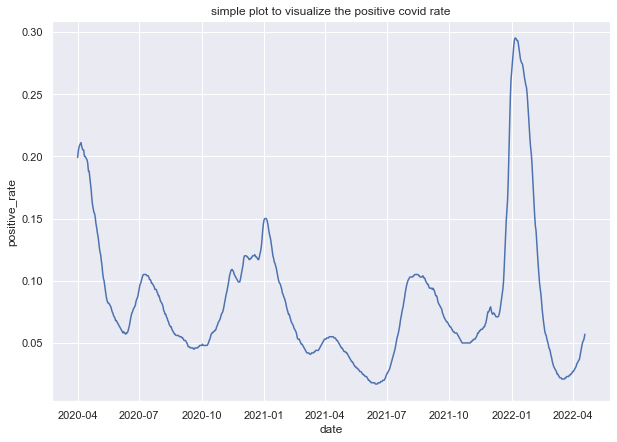

In [ ]:
plt.figure(figsize=(10,7))
sns.lineplot(data=df, x='date', y='positive_rate')
plt.title('simple plot to visualize the positive covid rate');

In [ ]:
# peak = '2021-09-01'
# sharp_decrease_df = df[(df.date <= peak)& (df.date >= '2021-07-01')]

# plt.figure(figsize=(10,7))
# sns.lineplot(data=sharp_decrease_df, x='date', y='positive_rate')
# # plt.title('(4) Sharp Decrease in Covid Cases (After Omicron)')
# plt.ylabel('Positive Rate')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.savefig('figures/(4) Sharp Decrease in Covid Cases (After Omicron).png');

# sd_avg = sharp_decrease_df.prediction.mean()
# print(f'The average sentiment score during the sharp decrease  in cases: {round(sd_avg,3)}')
# print(f'percent change from the average: {percent_change(sd_avg)}%')

# timeline_sharp_dec = daily_articles[(daily_articles.date <= peak) & (daily_articles.date >= '2021-07-01')]

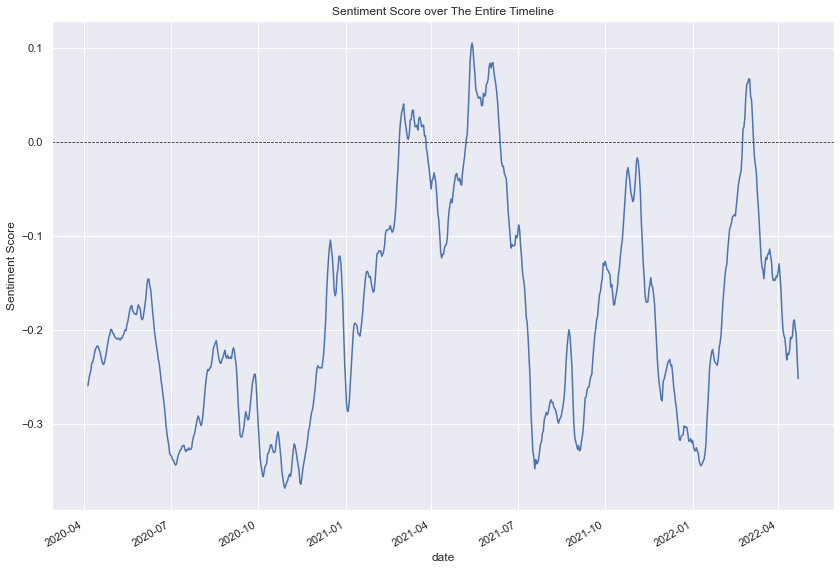

In [ ]:
fig = plt.figure(figsize=(14,10))
sns.lineplot(data=df, x='date', y='smoothed_prediction')
fig.autofmt_xdate()
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.75)
plt.title('Sentiment Score over The Entire Timeline')
plt.ylabel('Sentiment Score');

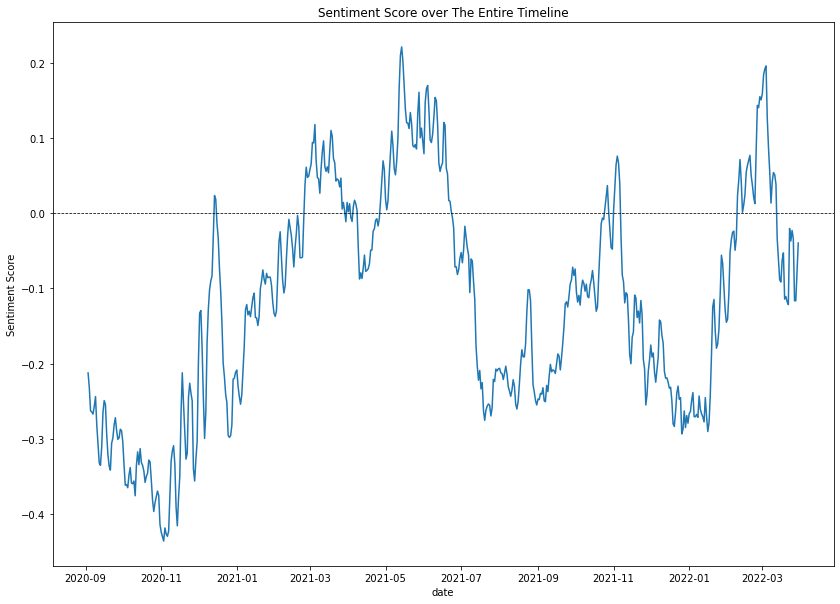

In [ ]:
plt.figure(figsize=(14,10))
sns.lineplot(data=df, x='date', y='avg_predict')
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.75)
plt.title('Sentiment Score over The Entire Timeline')
plt.ylabel('Sentiment Score');

In [ ]:
max_case = df[df.date < '2022-03-01'].positive_rate.argmax()
min_case = df[df.date < '2021-03-31'].positive_rate.argmin() # Finds the index of the peak or minimum.
df.iloc[max_case]

date                         2022-01-06 00:00:00
prediction                             -0.373418
articles_per_day                           638.0
new_cases_smoothed                    620422.143
new_deaths_smoothed                       1410.0
weekly_hosp_admissions                  127763.0
new_vaccinations_smoothed               956614.0
positive_rate                              0.295
new_cases                               835016.0
smoothed_prediction                     -0.32902
Name: 645, dtype: object

**Slow Decline in Cases**

The average sentiment score during the long decrease in cases: -0.12
percent change from the average: 34.7%


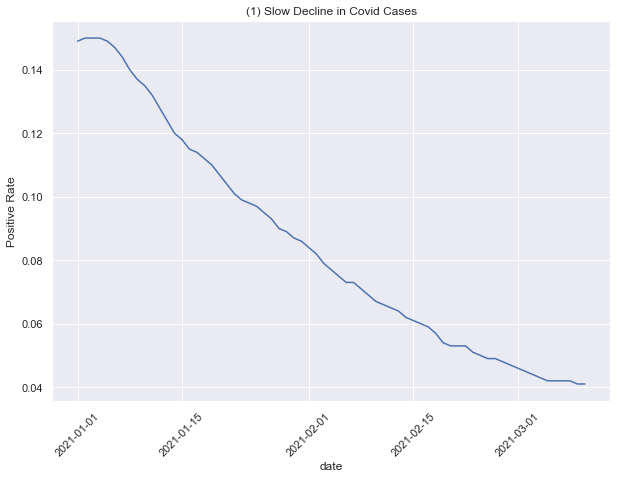

In [ ]:
peak_slow_dec = pd.to_datetime('2021-01-01')
start_slow_dec = pd.to_datetime('2021-3-10')
long_decrease_df = df[(df.date >= peak_slow_dec)& (df.date <= start_slow_dec)]
plt.figure(figsize=(10,7))
sns.lineplot(data=long_decrease_df, x='date', y='positive_rate');
plt.title('(1) Slow Decline in Covid Cases')
plt.ylabel('Positive Rate')
plt.xticks(rotation=45)

ld_avg = long_decrease_df.prediction.mean()
print(f'The average sentiment score during the long decrease in cases: {round(ld_avg,3)}')
print(f'percent change from the average: {percent_change(ld_avg)}%')
average_sentiment.append(ld_avg)
percent_change_avg.append(percent_change(ld_avg))
# timeline_slow_dec = daily_articles[(daily_articles.date >= peak_slow_dec)& (daily_articles.date <= '2021-3-10')]

# plt.savefig('figures/(1) Slow Decline in Covid Cases')

The average sentiment score during the long increase in cases: -0.336
percent change from the average: -82.7%


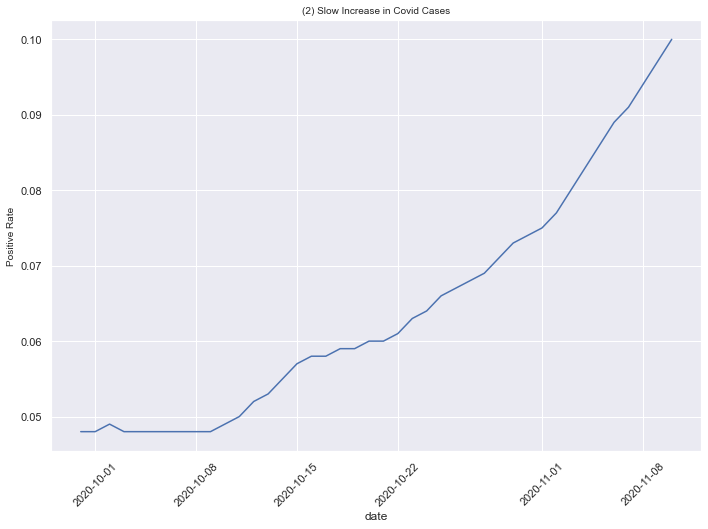

In [ ]:
peak_long_inc = pd.to_datetime('2020-09-30')
start_long_inc = pd.to_datetime('2020-11-10')
long_increase_df = df[(df.date >= peak_long_inc) & (df.date <= start_long_inc)]
plt.figure(figsize=(10,7))
sns.lineplot(data=long_increase_df, x='date', y='positive_rate')
plt.title('(2) Slow Increase in Covid Cases', fontsize=10)
plt.ylabel('Positive Rate', fontsize=10)
plt.tight_layout()
plt.xticks(rotation=45)

li_mean = long_increase_df.prediction.mean()
print(f'The average sentiment score during the long increase in cases: {round(li_mean,3)}')
print(f'percent change from the average: {percent_change(li_mean)}%')
average_sentiment.append(li_mean)
percent_change_avg.append(percent_change(li_mean))

# plt.savefig('figures/(2) Slow Increase in Covid Cases')

The average sentiment score during the long increase in cases: -0.05
percent change from the average: 72.6%


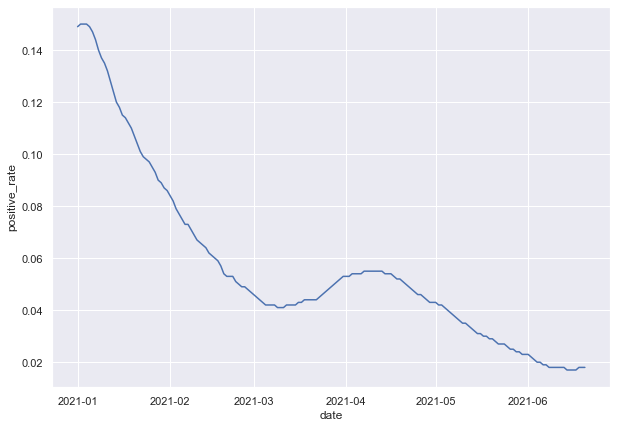

In [ ]:
delta_decrease_df = df[(df.date >= '2021-01-01') & (df.date <= '2021-06-20')]
plt.figure(figsize=(10,7))
sns.lineplot(data=delta_decrease_df, x='date', y='positive_rate')
li_mean = delta_decrease_df.prediction.mean()
print(f'The average sentiment score during the long increase in cases: {round(li_mean,3)}')
print(f'percent change from the average: {percent_change(li_mean)}%')

The average sentiment score during the sharp increase  in cases: -0.314
percent change from the average: -70.9%


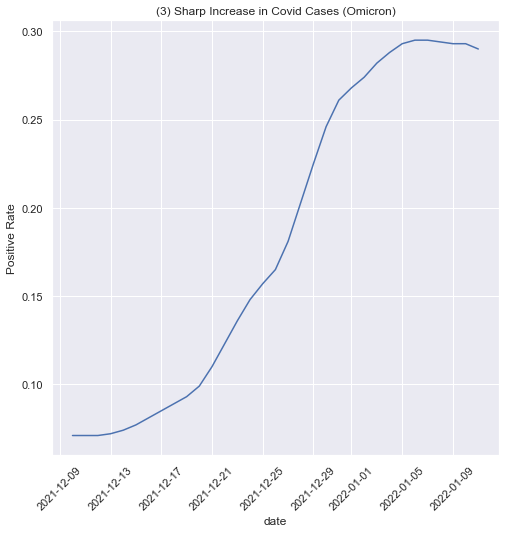

In [ ]:
peak_sharp_inc = pd.to_datetime('2022-01-11')
start_sharp_inc = pd.to_datetime('2021-12-10')

plt.figure(figsize=(8,8))
sharp_increase_df = df[(df.date <= peak_sharp_inc) & (df.date >= start_sharp_inc)]
sns.lineplot(data=sharp_increase_df, x='date', y='positive_rate')

plt.title('(3) Sharp Increase in Covid Cases (Omicron)')
plt.ylabel('Positive Rate')
plt.xticks(rotation=45)

si_avg = sharp_increase_df.prediction.mean()
print(f'The average sentiment score during the sharp increase  in cases: {round(si_avg,3)}')
print(f'percent change from the average: {percent_change(si_avg)}%')
average_sentiment.append(si_avg)
percent_change_avg.append(percent_change(si_avg))

# plt.savefig('figures/(3) Sharp Increase in Covid Cases (Omicron)')

In [ ]:
sharp_increase_df['date_ordinal'] = pd.to_datetime(sharp_increase_df['date']).apply(lambda date: date.toordinal())
long_increase_df['date_ordinal'] = pd.to_datetime(long_increase_df['date']).apply(lambda date: date.toordinal())

In [ ]:
plt.figure(figsize=(12,7))
sns.lineplot(data=long_decrease_df, x='date', y='avg_predict');
plt.ylabel('Sentiment Score')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Sentiment Score During Slow Decreasing Covid Cases')

ValueError: Could not interpret value `avg_predict` for parameter `y`

<Figure size 864x504 with 0 Axes>

The average sentiment score during the sharp decrease  in cases: -0.161
percent change from the average: 12.2%


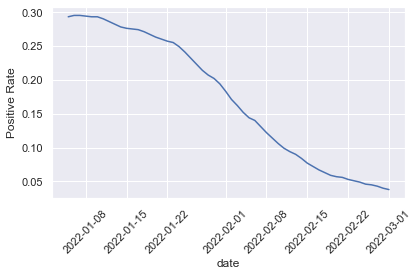

In [ ]:
peak_sharp_dec = pd.to_datetime('2022-01-05')
start_sharp_dec = pd.to_datetime('2022-03-01')

sharp_decrease_df = df[(df.date >= peak_sharp_dec)& (df.date <= start_sharp_dec)]
sns.lineplot(data=sharp_decrease_df, x='date', y='positive_rate')

plt.ylabel('Positive Rate')
plt.xticks(rotation=45)
plt.tight_layout()

sd_avg =sharp_decrease_df.prediction.mean()
print(f'The average sentiment score during the sharp decrease  in cases: {round(sd_avg,3)}')
print(f'percent change from the average: {percent_change(sd_avg)}%')
average_sentiment.append(sd_avg)
percent_change_avg.append(percent_change(sd_avg))

In [ ]:
# plt.figure(figsize=(14,10))
# sns.lineplot(data=df, x='date', y='positive_rate')

# plt.axvline(x=start_long_inc, color='k', linestyle='--', linewidth=0.75)
# plt.axvline(x=peak_long_inc, color='k', linestyle='--', linewidth=0.75)

# plt.axvline(x=start_sharp_dec, color='k', linestyle='--', linewidth=0.75)
# plt.axvline(x=peak_sharp_dec, color='k', linestyle='--', linewidth=0.75)

# plt.axvline(x=start_sharp_inc, color='k', linestyle='--', linewidth=0.75)
# plt.axvline(x=peak_sharp_inc, color='k', linestyle='--', linewidth=0.75)

# plt.axvline(x=start_slow_dec, color='k', linestyle='--', linewidth=0.75)
# plt.axvline(x=peak_slow_dec, color='k', linestyle='--', linewidth=0.75)

# plt.title('Four Timelines ')
# plt.ylabel('Covid Positive  Rate');

In [ ]:
long_decrease_df['date_ordinal'] = pd.to_datetime(long_decrease_df['date']).apply(lambda date: date.toordinal())
sharp_decrease_df['date_ordinal'] = pd.to_datetime(sharp_decrease_df['date']).apply(lambda date: date.toordinal())

/var/folders/7b/prbmv40d5wg4ymrn9dr3c76c0000gn/T/ipykernel_59389/176043633.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(new_labels)
/var/folders/7b/prbmv40d5wg4ymrn9dr3c76c0000gn/T/ipykernel_59389/176043633.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(new_labels)


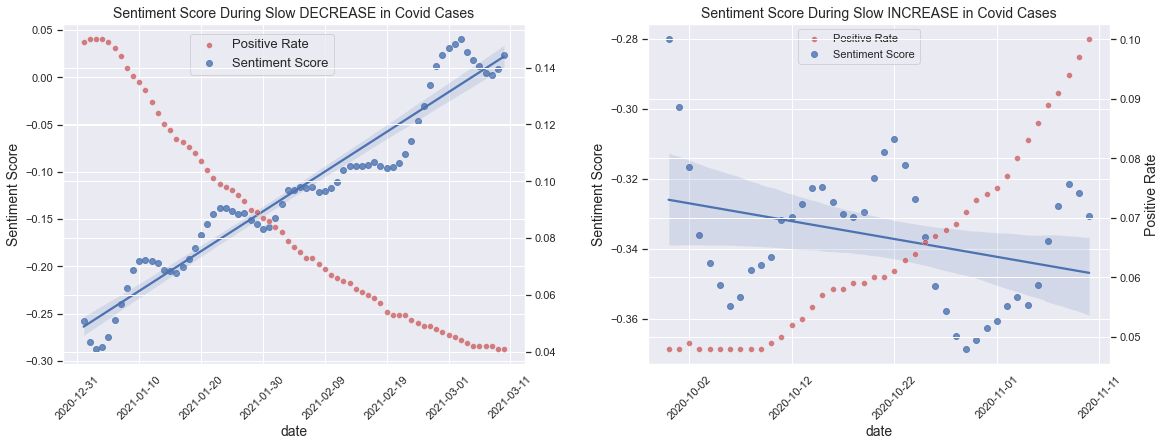

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))

odd_styles = dict(color='r', alpha=0.7, label='Covid Positive Rate', legend=False)

ax1 = sns.regplot(data=long_decrease_df, x='date_ordinal', y='smoothed_prediction', ax=ax1, label='Sentiment Score')
ax1.set_ylabel('Sentiment Score', fontsize=14)
ax1.set_xlabel('date', fontsize=14)
new_labels = [date.fromordinal(int(item)) for item in ax1.get_xticks()]
ax1.set_xticklabels(new_labels)
ax1.set_title('Sentiment Score During Slow DECREASE in Covid Cases', fontsize=14)

ax3 = ax1.twinx()
ax3 = sns.scatterplot(data=long_decrease_df, x='date_ordinal', y='positive_rate', ax=ax3, **odd_styles)
ax3.set_ylabel('')
lines, labels = ax3.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, bbox_to_anchor=(0.6, 0.99), fontsize=13)

ax2 = sns.regplot(data=long_increase_df, x='date_ordinal', y='smoothed_prediction', ax=ax2, label='Sentiment Score');
ax2.set_xlabel('date', fontsize=14)
new_labels = [date.fromordinal(int(item)) for item in ax2.get_xticks()]
ax2.set_xticklabels(new_labels)
ax2.set_ylabel('Sentiment Score', fontsize=14)
ax2.set_title('Sentiment Score During Slow INCREASE in Covid Cases', fontsize=14)
ax4 = ax2.twinx()
ax4 = sns.scatterplot(data=long_increase_df, x='date_ordinal', y='positive_rate', ax=ax4, **odd_styles)
ax4.set_ylabel('Positive Rate', fontsize=14)

lines3, labels = ax2.get_legend_handles_labels()
lines4, labels2 = ax4.get_legend_handles_labels()
ax2.legend(lines4 + lines3, labels2 + labels, bbox_to_anchor=(0.6, 1))

for ax in f.axes:
    plt.sca(ax);
    plt.xticks(rotation=45)

plt.tight_layout(pad=3.0);
f.savefig('figures/slow increase and decrease in cases regplot.png', dpi=500);

/var/folders/7b/prbmv40d5wg4ymrn9dr3c76c0000gn/T/ipykernel_59389/673542748.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(new_labels)
/var/folders/7b/prbmv40d5wg4ymrn9dr3c76c0000gn/T/ipykernel_59389/673542748.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(new_labels)


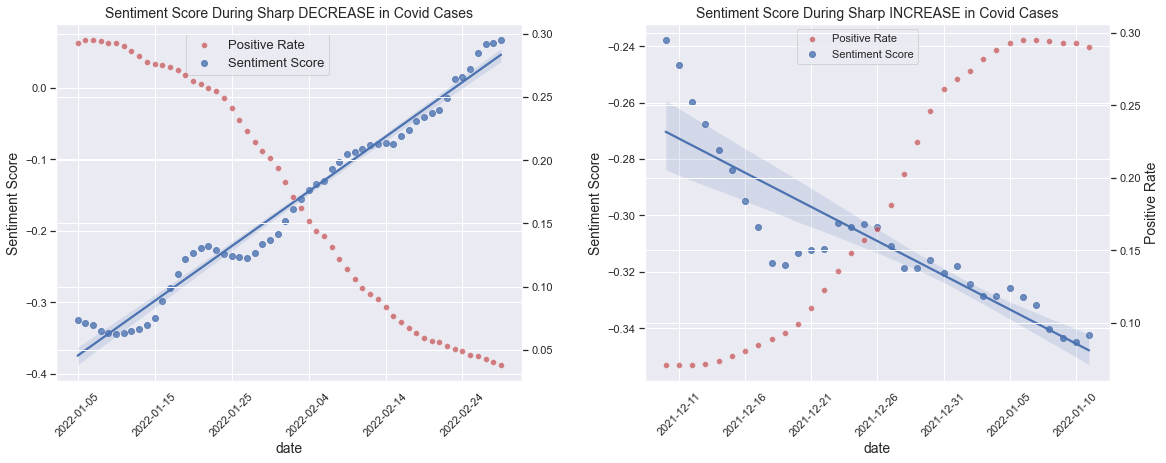

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))

ax1 = sns.regplot(data=sharp_decrease_df, x='date_ordinal', y='smoothed_prediction', ax=ax1, label='Sentiment Score')
ax1.set_ylabel('Sentiment Score', fontsize=14)
ax1.set_xlabel('date', fontsize=14)
new_labels = [date.fromordinal(int(item)) for item in ax1.get_xticks()]
ax1.set_xticklabels(new_labels)

ax3 = ax1.twinx()
ax3 = sns.scatterplot(data=sharp_decrease_df, x='date_ordinal', y='positive_rate', ax=ax3, color='r', alpha=0.7, label='Positive Rate', legend=False)
ax3.set_ylabel('')
lines, labels = ax3.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, bbox_to_anchor=(0.6, 0.99), fontsize=13)

ax2 = sns.regplot(data=sharp_increase_df, x='date_ordinal', y='smoothed_prediction', ax=ax2, label='Sentiment Score');
ax2.set_xlabel('date', fontsize=14)
new_labels = [date.fromordinal(int(item)) for item in ax2.get_xticks()]
ax2.set_xticklabels(new_labels)
ax2.set_ylabel('Sentiment Score', fontsize=14)
ax4 = ax2.twinx()
ax4 = sns.scatterplot(data=sharp_increase_df, x='date_ordinal', y='positive_rate', ax=ax4, color='r', alpha=0.7, label='Positive Rate', legend=False)
ax4.set_ylabel('Positive Rate', fontsize=14)

lines3, labels = ax2.get_legend_handles_labels()
lines4, labels2 = ax4.get_legend_handles_labels()
ax2.legend(lines4 + lines3, labels2 + labels, bbox_to_anchor=(0.6, 1))

for ax in f.axes:
    plt.sca(ax);
    plt.xticks(rotation=45);
plt.tight_layout(pad=3.0);
ax1.set_title('Sentiment Score During Sharp DECREASE in Covid Cases', fontsize=14)
ax2.set_title('Sentiment Score During Sharp INCREASE in Covid Cases', fontsize=14);
f.savefig('figures/sharp increase and decrease regplot.png', dpi=500);

In [ ]:
sentim_anal = pd.DataFrame({'Average Sentiment':average_sentiment, 'Percent Change': percent_change_avg})
sentim_anal = sentim_anal.round(2)
# sentim_anal['Percent Change'] = sentim_anal['Percent Change'].apply(lambda x: str(x)+'%')
sentim_anal['Percent Change'] = sentim_anal['Percent Change'].str.suffix('%')

sentim_anal.index = ['(1) Slow  Decrease', '(2) Sharp Decrease' , '(3) Slow  Increase', '(4) Sharp Increase']
sentim_anal.index.name = 'Change in Covid Cases'
slow_inc, sharp_inc, sharp_dec = sentim_anal.iloc[1].copy(), sentim_anal.iloc[2].copy(), sentim_anal.iloc[3].copy()
sentim_anal.iloc[1] = sharp_dec
sentim_anal.iloc[2] = slow_inc
sentim_anal.iloc[3] = sharp_inc
sentim_anal

NameError: name 'average_sentiment' is not defined

In [ ]:
sentim_anal.to_latex('latex_tables/percent_change_avg_sentim.tex')

/var/folders/7b/prbmv40d5wg4ymrn9dr3c76c0000gn/T/ipykernel_73144/2074057831.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  sentim_anal.to_latex('latex_tables/percent_change_avg_sentim.tex')


### Statistical Comparisons 

**Long Decrease**

In [ ]:
ld_pearson_corr, ld_pearson_p_val, ld_spearman_corr, ld_spearman_p_val, ld_kendal_corr, ld_kendal_p_val = run_corr(dataframe=long_decrease_df, predictor_list=predictor_list)
ld_analysis_df = pd.DataFrame({'Pearson Correlation' : ld_pearson_corr,'Spearman Correlation' : ld_spearman_corr, 'Kendall Correlation' : ld_kendal_corr})
ld_p_val_df = pd.DataFrame({'Pearson p-value': ld_pearson_p_val, 'Spearman p-value': ld_spearman_p_val, 'Kendall p-value': ld_kendal_p_val})
ld_analysis_df.index = predictor_list
ld_p_val_df.index = predictor_list
ld_analysis_df

,Pearson Correlation,Spearman Correlation,Kendall Correlation
new_cases,-0.765,-0.813,-0.591
new_cases_smoothed,-0.834,-0.878,-0.676
new_deaths_smoothed,-0.703,-0.704,-0.498
weekly_hosp_admissions,-0.870,-0.901,-0.710
positive_rate,-0.895,-0.922,-0.760


In [ ]:
# ld_pearson_corr = []
# ld_pearson_p_val = []
# for predictor in predictor_list:
#     corr, p_val = calc_corr(dataframe=delta_decrease_df, predictor=predictor)
#     ld_pearson_corr.append(corr)
#     ld_pearson_p_val.append(p_val)

# ld_spearman_corr = []
# ld_spearman_p_val = []
# for predictor in predictor_list:
#     corr, p_val = calc_corr(dataframe=delta_decrease_df, predictor=predictor, spearman=True)
#     ld_spearman_corr.append(corr)
#     ld_spearman_p_val.append(p_val)

# ld_kendal_corr = []
# ld_kendal_p_val = []
# for predictor in predictor_list:
#     corr, p_val = calc_corr(dataframe=delta_decrease_df,predictor=predictor, kend=True)
#     ld_kendal_corr.append(corr)
#     ld_kendal_p_val.append(p_val)

# ld_pearson_corr, ld_pearson_p_val, ld_spearman_corr, ld_spearman_p_val, ld_kendal_corr, ld_kendal_p_val = run_corr(dataframe=delta_decrease_df, predictor_list=predictor_list)

# ld_analysis_df = pd.DataFrame({'Pearson Correlation' : ld_pearson_corr,'Spearman Correlation' : ld_spearman_corr, 'Kendall Correlation' : ld_kendal_corr})
# ld_p_val_df = pd.DataFrame({'Pearson p-value': ld_pearson_p_val, 'Spearman p-value': ld_spearman_p_val, 'Kendall p-value': ld_kendal_p_val})
# ld_analysis_df.index = predictor_list
# ld_p_val_df.index = predictor_list
# ld_analysis_df

**Long Increase + Vaccines**

In [ ]:
non_na_preds

Index(['new_deaths_smoothed', 'weekly_hosp_admissions', 'positive_rate',
       'new_cases', 'avg_predict', 'num_articles'],
      dtype='object')

In [ ]:
li_pearson_corr, li_pearson_p_val, li_spearman_corr, li_spearman_p_val, li_kendal_corr, li_kendal_p_val = run_corr(dataframe=long_increase_df, predictor_list=non_na_preds[:-2])
li_analysis_df = pd.DataFrame({'Pearson Correlation' : li_pearson_corr,'Spearman Correlation' : li_spearman_corr, 'Kendall Correlation' : li_kendal_corr})
li_p_val_df = pd.DataFrame({'Pearson p-value': li_pearson_p_val, 'Spearman p-value': li_spearman_p_val, 'Kendall p-value': li_kendal_p_val})
li_analysis_df.index = non_na_preds[:-2]
li_p_val_df.index = non_na_preds[:-2]

In [ ]:
li_analysis_df

,Pearson Correlation,Spearman Correlation,Kendall Correlation
new_deaths_smoothed,-0.516,-0.495,-0.373
weekly_hosp_admissions,-0.530,-0.510,-0.375
positive_rate,-0.518,-0.478,-0.356
new_cases,-0.513,-0.436,-0.308


In [ ]:
li_p_val_df

,Pearson p-value,Spearman p-value,Kendall p-value
new_deaths_smoothed,0.0012,0.0018,0.0005
weekly_hosp_admissions,0.0002,0.0017,0.0006
positive_rate,0.0007,0.0031,0.0009
new_cases,0.0005,0.0077,0.0040


**Sharp Increase Omicron**

In [ ]:
si_pearson_corr, si_pearson_p_val, si_spearman_corr, si_spearman_p_val, si_kendal_corr, si_kendal_p_val = run_corr(dataframe=sharp_increase_df, predictor_list=predictor_list)

si_analysis_df = pd.DataFrame({'Pearson Correlation' : si_pearson_corr,'Spearman Correlation' : si_spearman_corr, 'Kendall Correlation' : si_kendal_corr})
si_p_val_df = pd.DataFrame({'Pearson p-value': si_pearson_p_val, 'Spearman p-value': si_spearman_p_val, 'Kendall p-value': si_kendal_p_val})
si_analysis_df.index = predictor_list
si_p_val_df.index = predictor_list

In [ ]:
si_analysis_df

,Pearson Correlation,Spearman Correlation,Kendall Correlation
new_cases,-0.343,-0.439,-0.290
new_cases_smoothed,-0.378,-0.552,-0.375
new_deaths_smoothed,-0.191,-0.248,-0.145
weekly_hosp_admissions,-0.351,-0.456,-0.294
positive_rate,-0.536,-0.581,-0.424


In [ ]:
si_p_val_df

,Pearson p-value,Spearman p-value,Kendall p-value
new_cases,0.03640,0.02480,0.02030
new_cases_smoothed,0.02170,0.00210,0.00220
new_deaths_smoothed,0.29539,0.33908,0.24989
weekly_hosp_admissions,0.03310,0.02020,0.01770
positive_rate,0.00130,0.00170,0.00070


**Sharp Decrease Omicron**

In [ ]:
sd_pearson_corr, sd_pearson_p_val, sd_spearman_corr, sd_spearman_p_val, sd_kendal_corr, sd_kendal_p_val = run_corr(dataframe=sharp_decrease_df, predictor_list=predictor_list)

sd_analysis_df = pd.DataFrame({'Pearson Correlation' : sd_pearson_corr,'Spearman Correlation' : sd_spearman_corr, 'Kendall Correlation' : sd_kendal_corr})
sd_p_val_df = pd.DataFrame({'Pearson p-value': sd_pearson_p_val, 'Spearman p-value': sd_spearman_p_val, 'Kendall p-value': sd_kendal_p_val})
sd_analysis_df.index = predictor_list
sd_p_val_df.index = predictor_list

In [ ]:
sd_analysis_df

,Pearson Correlation,Spearman Correlation,Kendall Correlation
new_cases,-0.804,-0.846,-0.631
new_cases_smoothed,-0.932,-0.923,-0.771
new_deaths_smoothed,0.269,0.188,0.106
weekly_hosp_admissions,-0.921,-0.913,-0.762
positive_rate,-0.957,-0.953,-0.814


In [ ]:
sd_p_val_df

,Pearson p-value,Spearman p-value,Kendall p-value
new_cases,0.0001,0.00010,0.00010
new_cases_smoothed,0.0001,0.00010,0.00010
new_deaths_smoothed,0.0458,0.32458,0.24929
weekly_hosp_admissions,0.0001,0.00010,0.00010
positive_rate,0.0001,0.00010,0.00010


In [ ]:
positive_rate_corr = pd.concat((sd_analysis_df.loc['positive_rate'],ld_analysis_df.loc['positive_rate'], 
            li_analysis_df.loc['positive_rate'], si_analysis_df.loc['positive_rate']),axis=1)

positive_rate_corr.columns = ['(1) Slow Decrease', '(2) Sharp Decrease', '(3) Slow Increase', '(4) Sharp Increase']
positive_rate_corr = positive_rate_corr.T
positive_rate_corr.index.name = 'Change in Covid Cases'
positive_rate_corr

,Pearson Correlation,Spearman Correlation,Kendall Correlation
Change in Covid Cases,,,
(1) Slow Decrease,-0.957,-0.953,-0.814
(2) Sharp Decrease,-0.895,-0.922,-0.760
(3) Slow Increase,-0.518,-0.478,-0.356
(4) Sharp Increase,-0.536,-0.581,-0.424


In [ ]:
positive_rate_corr.to_latex('latex_tables/positive rate correlations.tex')

/var/folders/7b/prbmv40d5wg4ymrn9dr3c76c0000gn/T/ipykernel_73144/3683922690.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  positive_rate_corr.to_latex('latex_tables/positive rate correlations.tex')


In [ ]:
print(sharp_decrease_df.num_articles.min())
print(sharp_increase_df.num_articles.min())
print(long_increase_df.num_articles.min())
print(long_decrease_df.num_articles.min())

80
111
183
186


# Testing Section

In [ ]:
pre_df = pd.read_csv('csv/us_apr-feb2021.csv', index_col=[0])
pre_df['smooth_prediction'] = pre_df.prediction.rolling(4, center=True).mean()
post_df = pd.read_csv('csv/us-mar-apr2022.csv', index_col=[0])
post_df['smooth_prediction'] = post_df.prediction.rolling(4, center=True).mean()
df = pd.concat((pre_df,post_df),axis=0)
df.date = pd.to_datetime(df.date)
# new_df.set_index('date')


<AxesSubplot:>

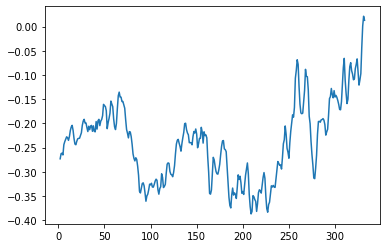

In [ ]:
pre_df.smooth_prediction.plot()

In [ ]:
new_df.plot(x="date", y="smooth_prediction", legend=False, color ='r',figsize=(13,8), label='new')
df.plot(x="date", y="avg_predict", ax=ax2, legend=False, label='old')

In [ ]:
new_df.date

0      2020-04-01
1      2020-04-02
2      2020-04-03
3      2020-04-04
4      2020-04-05
          ...    
421    2022-04-26
422    2022-04-27
423    2022-04-28
424    2022-04-29
425    2022-04-30
Name: date, Length: 760, dtype: object

Text(0.5, 0, 'Date')

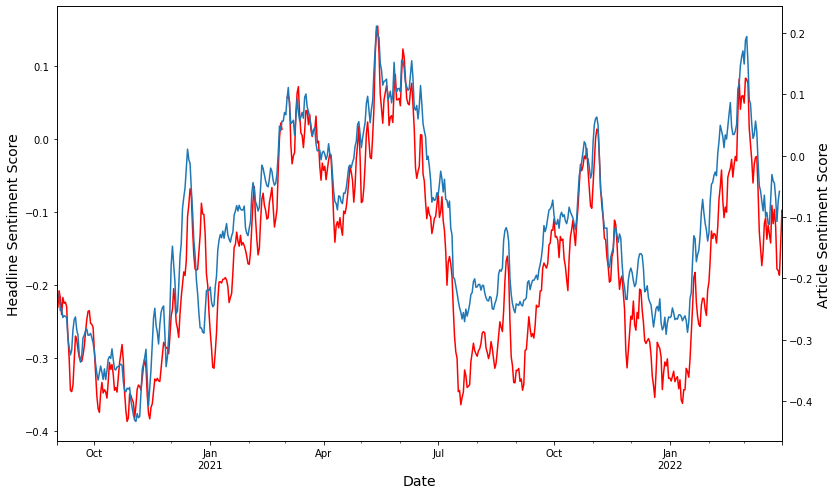

In [ ]:
ax = new_df.plot(x="date", y="smooth_prediction", legend=False, color ='r',figsize=(13,8), label='new')
ax2 = ax.twinx()
df.plot(x="date", y="avg_predict", ax=ax2, legend=False, label='old')

# plt.title('Comparing Average Daily Article Sentiment Against New Covid Cases')
ax.set_ylabel('Headline Sentiment Score', fontsize=14)
ax2.set_ylabel('Article Sentiment Score', fontsize=14)
ax.set_xlabel('Date', fontsize=14)

<AxesSubplot:>

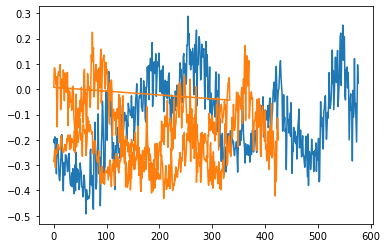

In [ ]:
df.prediction.plot()
new_df.prediction.plot()